In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [8]:
class State:

    def __init__(self, n1, n2, n3, n4=None):
        self.player_current_sum = n1
        self.dealer_showing_card = n2
        self.player_usable_ace = n3
        self.action = n4

In [9]:
class BlackJack:

    def __init__(self):

        self.player_policy = dict()
        for i in range(20):
            self.player_policy[i] = "hit"
        self.player_policy[20] = "stick"
        self.player_policy[21] = "stick"

        self.dealer_policy = dict()
        for i in range(17):
            self.dealer_policy[i] = "hit"
        for i in range(17, 22):
            self.dealer_policy[i] = "stick"

        player_current_sum = 0
        self.dealer_current_sum = 0
        player_usable_ace = False
        self.dealer_usable_ace = False

        while player_current_sum < 12:
            card = self.hit()
            if card == 1:
                temp_sum = player_current_sum + 11
                if temp_sum <= 21:
                    player_usable_ace = True
                    player_current_sum = temp_sum
                else:
                    player_current_sum = player_current_sum + 1
            else:
                player_current_sum = player_current_sum + card

        dealer_showing_card = self.hit()
        dealer_not_showing_card = self.hit()
        self.initial_state = State(player_current_sum, dealer_showing_card, player_usable_ace)

        if dealer_showing_card == 1 and dealer_not_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 12
        elif dealer_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 11 + dealer_not_showing_card
        elif dealer_not_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 11 + dealer_showing_card
        else:
            self.dealer_usable_ace = False
            self.dealer_current_sum = dealer_showing_card + dealer_not_showing_card

    def hit(self):

        card = np.random.randint(1, 14)
        return min(10, card)

    def play_game(self):
        episode = list()
        current_state = self.initial_state

        while True:
            if current_state.action is None:
                current_state.action = self.player_policy[current_state.player_current_sum]
            episode.append([current_state, current_state.action])
            player_current_sum = current_state.player_current_sum
            player_usable_ace = current_state.player_usable_ace

            if current_state.action == "hit":
                card = self.hit()
                if card == 1:
                    if current_state.player_usable_ace:
                        ace_count = 1
                    else:
                        ace_count = 0
                    ace_count += 1
                    player_current_sum = player_current_sum + 11
                    while player_current_sum > 21 and ace_count:
                        player_current_sum = player_current_sum - 10
                        ace_count -= 1
                    if player_current_sum > 21:
                        return episode, -1
                    if ace_count == 1:
                        player_usable_ace = True
                    else:
                        player_usable_ace = False
                else:
                    player_current_sum = current_state.player_current_sum + card
                if player_current_sum > 21 and player_usable_ace:
                    player_current_sum = player_current_sum - 10
                    player_usable_ace = False
                elif player_current_sum > 21:
                    return episode, -1
            else:
                break
            current_state = State(player_current_sum, current_state.dealer_showing_card, player_usable_ace)

        while True:
            dealer_action = self.dealer_policy[self.dealer_current_sum]
            if dealer_action == "hit":
                card = self.hit()
                if card == 1:
                    ace_count = 0
                    if self.dealer_usable_ace:
                        ace_count = 1
                    ace_count += 1
                    self.dealer_current_sum += 11
                    while self.dealer_current_sum > 21 and ace_count:
                        self.dealer_current_sum -= 10
                        ace_count -= 1
                    if self.dealer_current_sum > 21:
                        return episode, 1
                    if ace_count == 1:
                        self.dealer_usable_ace = True
                    else:
                        self.dealer_usable_ace = False
                else:
                    self.dealer_current_sum += card
                if self.dealer_current_sum > 21 and self.dealer_usable_ace:
                    self.dealer_current_sum = self.dealer_current_sum - 10
                    self.dealer_usable_ace = False
                elif self.dealer_current_sum > 21:
                    return episode, 1
            else:
                break

        if current_state.player_current_sum > self.dealer_current_sum:
            return episode, 1
        elif current_state.player_current_sum == self.dealer_current_sum:
            return episode, 0
        else:
            return episode, -1


In [10]:
class MonteCarloPrediction:

    def __init__(self, n):
        self.no_of_episodes = n
        self.state_value_usable_ace = np.zeros((10, 10))
        self.count_usable_ace = np.ones((10, 10))
        self.state_value_no_usable_ace = np.zeros((10, 10))
        self.count_no_usable_ace = np.ones((10, 10))

    def every_visit_on_policy(self):
        for i in range(self.no_of_episodes):
            black_jack_obj = BlackJack()
            episode, reward = black_jack_obj.play_game()
            t = len(episode) - 1
            while t >= 0:
                s_t = episode[t][0]
                index_player_sum = s_t.player_current_sum - 12
                index_dealer_showing_card = s_t.dealer_showing_card - 1
                if s_t.player_usable_ace:
                    self.state_value_usable_ace[index_player_sum, index_dealer_showing_card] += reward
                    self.count_usable_ace[index_player_sum, index_dealer_showing_card] += 1
                else:
                    self.state_value_no_usable_ace[index_player_sum, index_dealer_showing_card] += reward
                    self.count_no_usable_ace[index_player_sum, index_dealer_showing_card] += 1
                t = t - 1
        state_value_usable_ace = self.state_value_usable_ace/self.count_usable_ace
        state_value_no_usable_ace = self.state_value_no_usable_ace/self.count_no_usable_ace
        return state_value_usable_ace, state_value_no_usable_ace


In [11]:
def plot_fig_5_1():

    monte_carlo_obj = MonteCarloPrediction(10000)
    state_value_usable_ace, state_value_no_usable_ace = monte_carlo_obj.every_visit_on_policy()
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(221, projection='3d')
    X = np.arange(10)
    Y = np.arange(10)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, state_value_usable_ace, cmap="hot")
    ax.set_title("Usable ace, 10000 episodes")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

    ax = fig.add_subplot(223, projection='3d')
    ax.plot_surface(X, Y, state_value_no_usable_ace, cmap="hot")
    ax.set_title("No usable ace, 10000 episodes")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

    monte_carlo_obj = MonteCarloPrediction(500000)
    state_value_usable_ace, state_value_no_usable_ace = monte_carlo_obj.every_visit_on_policy()
    ax = fig.add_subplot(222, projection='3d')
    ax.plot_surface(X, Y, state_value_usable_ace, cmap="hot")
    ax.set_title("Usable ace, 500000 episodes")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

    ax = fig.add_subplot(224, projection='3d')
    ax.plot_surface(X, Y, state_value_no_usable_ace, cmap="hot")
    ax.set_title("No usable ace, 500000 episodes")
    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
    plt.savefig('figure_5_1.png')
    plt.show()
    plt.close()


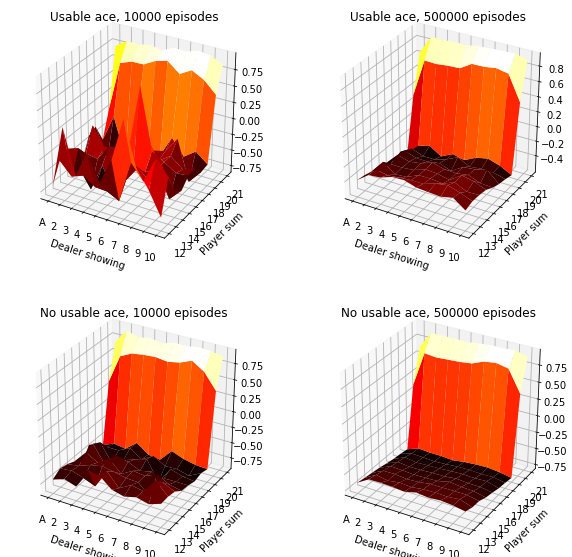

In [12]:
plot_fig_5_1()